# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.349
[2] loss: 0.212
[3] loss: 0.052
[4] loss: 0.028
[5] loss: 0.019
[6] loss: 0.013
[7] loss: 0.011
[8] loss: 0.010
[9] loss: 0.005
[10] loss: 0.007
[11] loss: 0.007
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.003
[15] loss: 0.003
[16] loss: 0.005
[17] loss: 0.002
[18] loss: 0.006
[19] loss: 0.003
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

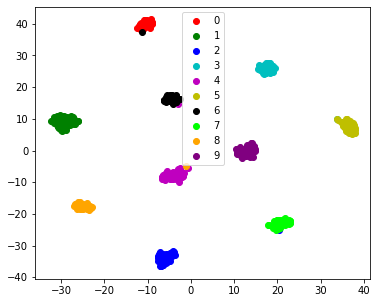

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

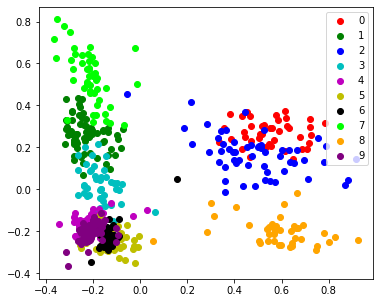

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.4849, -0.2541,  0.4987, -0.1834, -0.2235, -0.1332, -0.1278, -0.2028,
          0.5908, -0.2270],
        [-0.3029, -0.0146, -0.2818,  0.1170,  0.3021, -0.1969, -0.3074,  0.1061,
          0.2932,  0.3346],
        [ 0.2432,  0.2868,  0.1644,  0.0385, -0.1638, -0.2405, -0.2084,  0.5195,
         -0.2146, -0.1994],
        [ 0.3175,  0.5185, -0.2124, -0.1763, -0.1920, -0.1465,  0.3911, -0.2315,
         -0.0547,  0.2870],
        [-0.2540,  0.2809,  0.3079, -0.2276,  0.3510,  0.3682, -0.1065, -0.1489,
         -0.0941, -0.2063],
        [ 0.3217,  0.0796, -0.0595,  0.5437, -0.0511,  0.3501, -0.0939, -0.1221,
         -0.0936, -0.1234],
        [-0.0604, -0.5168,  0.1080, -0.2126,  0.1332, -0.3552,  0.3566, -0.3711,
         -0.4439, -0.0184],
        [ 0.3419, -0.2057, -0.1873, -0.3093, -0.2044,  0.3864, -0.2836,  0.3426,
         -0.1870,  0.3609]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_12.cfg')

['./config/sswae_dev2_1_12.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 8
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.309678e-01  D: 6.904375e-01  D2: 4.888938e-02  D3: 2.730034e-03
test loss: 1.697524e-01  D: 6.990296e-01  D2: 2.385255e-02  D3: 5.245357e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.610774e-01  D: 6.947126e-01  D2: 1.346339e-02  D3: 5.173076e-03
test loss: 1.623436e-01  D: 7.215242e-01  D2: 6.666393e-03  D3: 7.165609e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.341399e-01  D: 6.940839e-01  D2: 4.164511e-03  D3: 5.638443e-03
test loss: 1.183572e-01  D: 6.890457e-01  D2: 1.260834e-03  D3: 5.435786e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.046118e-01  D: 6.934956e-01  D2: 3.257767e-04  D3: 5.532559e-03
test loss: 8.778671e-02  D: 6.915852e-01  D2: -1.388884e-03  D3: 4.758156e-03


[default |INFO|model.py:1280] [05/80]  loss: 7.957542e-02  D: 6.921866e-01  D2: -1.814092e-03  D3: 4.103627e-03
test loss: 7.246426e-02  D: 7.146919e-01  D2: -2.520657e-03  D3: 4.567213e-03


[default |INFO|model.py:1280] [06/80]  loss: 8.408213e-02  D: 6.984092e-01  D2: -2.955050e-03  D3: 7.197739e-03
test loss: 6.813850e-02  D: 6.947513e-01  D2: -3.083344e-03  D3: 6.434324e-03


[default |INFO|model.py:1280] [07/80]  loss: 7.802585e-02  D: 6.948693e-01  D2: -3.230896e-03  D3: 1.148710e-02
test loss: 7.533439e-02  D: 6.803684e-01  D2: -3.839636e-03  D3: 1.296598e-02


[default |INFO|model.py:1280] [08/80]  loss: 6.939393e-02  D: 6.935668e-01  D2: -3.640841e-03  D3: 1.128689e-02
test loss: 6.735654e-02  D: 6.684174e-01  D2: -3.815289e-03  D3: 1.374282e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.508675e-02  D: 6.948837e-01  D2: -3.612431e-03  D3: 1.360548e-02
test loss: 7.338513e-02  D: 6.826689e-01  D2: -2.739525e-03  D3: 1.163790e-02


[default |INFO|model.py:1280] [10/80]  loss: 6.687151e-02  D: 6.934636e-01  D2: -4.024781e-03  D3: 1.403782e-02
test loss: 6.442229e-02  D: 6.846897e-01  D2: -4.045963e-03  D3: 1.460788e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.794953e-02  D: 6.942055e-01  D2: -3.915404e-03  D3: 1.251802e-02
test loss: 6.377414e-02  D: 6.957058e-01  D2: -4.241953e-03  D3: 1.005769e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.301050e-02  D: 6.937555e-01  D2: -4.272838e-03  D3: 1.344404e-02
test loss: 6.035991e-02  D: 6.936309e-01  D2: -2.706881e-03  D3: 1.428263e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.289548e-02  D: 6.937923e-01  D2: -4.465276e-03  D3: 1.268052e-02
test loss: 5.967111e-02  D: 6.935054e-01  D2: -4.152479e-03  D3: 1.105114e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.150674e-02  D: 6.933343e-01  D2: -4.451569e-03  D3: 1.250943e-02
test loss: 6.363347e-02  D: 6.963617e-01  D2: -4.513216e-03  D3: 1.033098e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.507785e-02  D: 6.946088e-01  D2: -4.666271e-03  D3: 1.091359e-02
test loss: 6.180478e-02  D: 6.957756e-01  D2: -4.163303e-03  D3: 1.094545e-02


[default |INFO|model.py:1280] [16/80]  loss: 5.954200e-02  D: 6.939955e-01  D2: -4.829605e-03  D3: 1.255107e-02
test loss: 5.798968e-02  D: 7.018627e-01  D2: -4.822502e-03  D3: 1.060341e-02


[default |INFO|model.py:1280] [17/80]  loss: 5.799819e-02  D: 6.948340e-01  D2: -4.775508e-03  D3: 1.317840e-02
test loss: 5.618136e-02  D: 6.816713e-01  D2: -4.242945e-03  D3: 1.489759e-02


[default |INFO|model.py:1280] [18/80]  loss: 5.648973e-02  D: 6.937992e-01  D2: -4.940372e-03  D3: 1.327770e-02
test loss: 5.481176e-02  D: 7.125601e-01  D2: -5.240126e-03  D3: 1.220516e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.401721e-02  D: 6.930556e-01  D2: -4.999566e-03  D3: 1.368580e-02
test loss: 5.113057e-02  D: 6.824918e-01  D2: -4.629440e-03  D3: 1.530914e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.588112e-02  D: 6.941445e-01  D2: -5.198752e-03  D3: 1.312100e-02
test loss: 5.612409e-02  D: 6.961443e-01  D2: -5.070667e-03  D3: 1.255795e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.609747e-02  D: 6.952013e-01  D2: -5.100362e-03  D3: 1.271146e-02
test loss: 5.623788e-02  D: 7.122328e-01  D2: -5.194740e-03  D3: 1.469428e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.136385e-02  D: 6.923930e-01  D2: -5.295018e-03  D3: 1.357215e-02
test loss: 4.940358e-02  D: 6.886772e-01  D2: -5.420141e-03  D3: 1.550791e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.372873e-02  D: 6.945287e-01  D2: -5.454434e-03  D3: 1.325546e-02
test loss: 5.025152e-02  D: 6.665935e-01  D2: -5.270290e-03  D3: 1.479557e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.029651e-02  D: 6.920078e-01  D2: -5.597134e-03  D3: 1.364948e-02
test loss: 4.781804e-02  D: 6.765736e-01  D2: -6.092758e-03  D3: 1.215025e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.456753e-02  D: 6.947704e-01  D2: -5.676878e-03  D3: 1.229181e-02
test loss: 4.789866e-02  D: 7.016434e-01  D2: -5.695925e-03  D3: 1.406233e-02


[default |INFO|model.py:1280] [26/80]  loss: 4.799895e-02  D: 6.932582e-01  D2: -5.720261e-03  D3: 1.387108e-02
test loss: 4.771256e-02  D: 6.927127e-01  D2: -4.991274e-03  D3: 1.536489e-02


[default |INFO|model.py:1280] [27/80]  loss: 4.797210e-02  D: 6.946862e-01  D2: -5.681936e-03  D3: 1.366313e-02
test loss: 4.988679e-02  D: 6.839953e-01  D2: -5.486870e-03  D3: 1.536502e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.158545e-02  D: 6.936750e-01  D2: -5.787673e-03  D3: 1.265721e-02
test loss: 4.993243e-02  D: 6.918706e-01  D2: -6.003771e-03  D3: 1.254743e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.163959e-02  D: 6.936196e-01  D2: -6.146873e-03  D3: 1.293008e-02
test loss: 5.348622e-02  D: 6.945139e-01  D2: -4.995842e-03  D3: 1.526404e-02


[default |INFO|model.py:1280] [30/80]  loss: 4.794135e-02  D: 6.920849e-01  D2: -5.988180e-03  D3: 1.356949e-02
test loss: 4.931083e-02  D: 6.920657e-01  D2: -5.212488e-03  D3: 1.247004e-02


[default |INFO|model.py:1280] [31/80]  loss: 4.883100e-02  D: 6.932032e-01  D2: -6.252146e-03  D3: 1.277543e-02
test loss: 4.802498e-02  D: 7.036611e-01  D2: -5.777121e-03  D3: 1.433598e-02


[default |INFO|model.py:1280] [32/80]  loss: 4.549395e-02  D: 6.930255e-01  D2: -6.331482e-03  D3: 1.367718e-02
test loss: 4.605062e-02  D: 6.860556e-01  D2: -6.352262e-03  D3: 1.399087e-02


[default |INFO|model.py:1280] [33/80]  loss: 4.675659e-02  D: 6.925662e-01  D2: -6.303622e-03  D3: 1.347686e-02
test loss: 4.700846e-02  D: 6.811937e-01  D2: -6.474276e-03  D3: 1.305613e-02


[default |INFO|model.py:1280] [34/80]  loss: 4.695081e-02  D: 6.954025e-01  D2: -6.385193e-03  D3: 1.330860e-02
test loss: 4.639237e-02  D: 6.832862e-01  D2: -6.329546e-03  D3: 1.533382e-02


[default |INFO|model.py:1280] [35/80]  loss: 4.682153e-02  D: 6.921952e-01  D2: -6.539817e-03  D3: 1.321258e-02
test loss: 4.613793e-02  D: 6.946271e-01  D2: -6.890173e-03  D3: 1.121015e-02


[default |INFO|model.py:1280] [36/80]  loss: 4.617465e-02  D: 6.944497e-01  D2: -6.676752e-03  D3: 1.329034e-02
test loss: 4.417991e-02  D: 6.991844e-01  D2: -7.140827e-03  D3: 1.466559e-02


[default |INFO|model.py:1280] [37/80]  loss: 4.437529e-02  D: 6.938945e-01  D2: -6.781700e-03  D3: 1.362410e-02
test loss: 4.468198e-02  D: 6.777179e-01  D2: -6.969395e-03  D3: 1.496830e-02


[default |INFO|model.py:1280] [38/80]  loss: 4.362944e-02  D: 6.945340e-01  D2: -6.895157e-03  D3: 1.360043e-02
test loss: 4.410906e-02  D: 6.878585e-01  D2: -6.465664e-03  D3: 1.237647e-02


[default |INFO|model.py:1280] [39/80]  loss: 4.447833e-02  D: 6.932846e-01  D2: -6.894536e-03  D3: 1.346229e-02
test loss: 4.727821e-02  D: 6.856766e-01  D2: -6.359243e-03  D3: 1.515058e-02


[default |INFO|model.py:1280] [40/80]  loss: 4.337937e-02  D: 6.935062e-01  D2: -6.905595e-03  D3: 1.365544e-02
test loss: 4.382539e-02  D: 6.951198e-01  D2: -7.183352e-03  D3: 1.505353e-02


[default |INFO|model.py:1280] [41/80]  loss: 4.326504e-02  D: 6.935986e-01  D2: -7.035287e-03  D3: 1.372471e-02
test loss: 4.326911e-02  D: 6.946256e-01  D2: -7.239208e-03  D3: 1.303470e-02


[default |INFO|model.py:1280] [42/80]  loss: 4.313359e-02  D: 6.936745e-01  D2: -7.139586e-03  D3: 1.340844e-02
test loss: 4.732505e-02  D: 7.132080e-01  D2: -6.933069e-03  D3: 1.265887e-02


[default |INFO|model.py:1280] [43/80]  loss: 4.593507e-02  D: 6.930462e-01  D2: -7.163210e-03  D3: 1.314437e-02
test loss: 4.572941e-02  D: 6.915054e-01  D2: -7.201567e-03  D3: 1.134400e-02


[default |INFO|model.py:1280] [44/80]  loss: 4.629673e-02  D: 6.935637e-01  D2: -7.203514e-03  D3: 1.281311e-02
test loss: 4.470878e-02  D: 7.073280e-01  D2: -7.142572e-03  D3: 1.317752e-02


[default |INFO|model.py:1280] [45/80]  loss: 4.352360e-02  D: 6.937406e-01  D2: -7.261906e-03  D3: 1.349640e-02
test loss: 4.233605e-02  D: 6.910609e-01  D2: -7.062054e-03  D3: 1.355020e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.266232e-02  D: 6.936028e-01  D2: -7.327449e-03  D3: 1.362534e-02
test loss: 4.431313e-02  D: 6.945269e-01  D2: -7.507219e-03  D3: 1.367744e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.325787e-02  D: 6.931838e-01  D2: -7.464396e-03  D3: 1.327229e-02
test loss: 4.476338e-02  D: 6.888073e-01  D2: -7.447882e-03  D3: 1.315227e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.294434e-02  D: 6.939165e-01  D2: -7.478495e-03  D3: 1.335556e-02
test loss: 4.344845e-02  D: 6.957242e-01  D2: -7.189407e-03  D3: 1.431207e-02


[default |INFO|model.py:1280] [49/80]  loss: 4.311110e-02  D: 6.934321e-01  D2: -7.484223e-03  D3: 1.346734e-02
test loss: 4.325461e-02  D: 6.958415e-01  D2: -7.503443e-03  D3: 1.450004e-02


[default |INFO|model.py:1280] [50/80]  loss: 4.246692e-02  D: 6.934787e-01  D2: -7.558562e-03  D3: 1.336070e-02
test loss: 4.318923e-02  D: 6.938090e-01  D2: -7.606401e-03  D3: 1.395183e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.294718e-02  D: 6.938852e-01  D2: -7.620619e-03  D3: 1.325730e-02
test loss: 4.276587e-02  D: 7.005910e-01  D2: -7.256727e-03  D3: 1.375763e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.271454e-02  D: 6.932164e-01  D2: -7.611483e-03  D3: 1.337961e-02
test loss: 4.396397e-02  D: 6.878779e-01  D2: -7.952900e-03  D3: 1.321967e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.207275e-02  D: 6.933893e-01  D2: -7.807458e-03  D3: 1.337532e-02
test loss: 4.366957e-02  D: 6.938147e-01  D2: -7.403250e-03  D3: 1.331451e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.204491e-02  D: 6.937054e-01  D2: -7.707378e-03  D3: 1.345143e-02
test loss: 4.378940e-02  D: 7.005469e-01  D2: -8.162317e-03  D3: 1.370206e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.145321e-02  D: 6.940595e-01  D2: -7.872564e-03  D3: 1.335293e-02
test loss: 4.355341e-02  D: 6.939111e-01  D2: -7.985497e-03  D3: 1.210382e-02


[default |INFO|model.py:1280] [56/80]  loss: 4.227513e-02  D: 6.942122e-01  D2: -7.836421e-03  D3: 1.332903e-02
test loss: 4.269606e-02  D: 6.983822e-01  D2: -7.907200e-03  D3: 1.353873e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.194203e-02  D: 6.931901e-01  D2: -7.929969e-03  D3: 1.342543e-02
test loss: 4.377442e-02  D: 7.008721e-01  D2: -8.141861e-03  D3: 1.356687e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.110358e-02  D: 6.931151e-01  D2: -7.992050e-03  D3: 1.337527e-02
test loss: 4.354846e-02  D: 6.920396e-01  D2: -8.165131e-03  D3: 1.291084e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.151669e-02  D: 6.941100e-01  D2: -8.037024e-03  D3: 1.335463e-02
test loss: 4.332130e-02  D: 6.902095e-01  D2: -8.265724e-03  D3: 1.300289e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.162148e-02  D: 6.942091e-01  D2: -8.058318e-03  D3: 1.324473e-02
test loss: 4.341059e-02  D: 6.860539e-01  D2: -8.108358e-03  D3: 1.421164e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.149331e-02  D: 6.934795e-01  D2: -8.085478e-03  D3: 1.323750e-02
test loss: 4.371883e-02  D: 6.916471e-01  D2: -8.385601e-03  D3: 1.176404e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.107990e-02  D: 6.937030e-01  D2: -8.249979e-03  D3: 1.309161e-02
test loss: 4.284051e-02  D: 6.903043e-01  D2: -7.926197e-03  D3: 1.365254e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.086526e-02  D: 6.935182e-01  D2: -8.193394e-03  D3: 1.315221e-02
test loss: 4.237574e-02  D: 6.979267e-01  D2: -7.906475e-03  D3: 1.293920e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.048497e-02  D: 6.930550e-01  D2: -8.252306e-03  D3: 1.322458e-02
test loss: 4.276236e-02  D: 6.835630e-01  D2: -8.095684e-03  D3: 1.420606e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.072631e-02  D: 6.939532e-01  D2: -8.257414e-03  D3: 1.324412e-02
test loss: 4.364738e-02  D: 6.906240e-01  D2: -8.337927e-03  D3: 1.257779e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.121325e-02  D: 6.930042e-01  D2: -8.331877e-03  D3: 1.313679e-02
test loss: 4.291862e-02  D: 6.895329e-01  D2: -8.291540e-03  D3: 1.252986e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.062377e-02  D: 6.937862e-01  D2: -8.432630e-03  D3: 1.314811e-02
test loss: 4.341336e-02  D: 6.938984e-01  D2: -8.311386e-03  D3: 1.265140e-02


[default |INFO|model.py:1280] [68/80]  loss: 3.987694e-02  D: 6.935406e-01  D2: -8.535466e-03  D3: 1.309580e-02
test loss: 4.212579e-02  D: 6.738523e-01  D2: -8.544970e-03  D3: 1.365644e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.005426e-02  D: 6.942014e-01  D2: -8.431371e-03  D3: 1.310166e-02
test loss: 4.223968e-02  D: 7.075293e-01  D2: -8.746653e-03  D3: 1.298159e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.063680e-02  D: 6.933281e-01  D2: -8.469046e-03  D3: 1.309120e-02
test loss: 4.168499e-02  D: 7.103731e-01  D2: -8.413811e-03  D3: 1.385488e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.049998e-02  D: 6.939531e-01  D2: -8.495232e-03  D3: 1.302479e-02
test loss: 4.185636e-02  D: 7.103390e-01  D2: -8.321810e-03  D3: 1.257292e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.027158e-02  D: 6.928597e-01  D2: -8.481614e-03  D3: 1.318682e-02
test loss: 4.108541e-02  D: 6.922227e-01  D2: -8.446712e-03  D3: 1.316870e-02


[default |INFO|model.py:1280] [73/80]  loss: 3.950013e-02  D: 6.937298e-01  D2: -8.534937e-03  D3: 1.310049e-02
test loss: 4.195875e-02  D: 6.927963e-01  D2: -8.136435e-03  D3: 1.370457e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.018536e-02  D: 6.934207e-01  D2: -8.579995e-03  D3: 1.307171e-02
test loss: 4.359846e-02  D: 7.067282e-01  D2: -8.775740e-03  D3: 1.293720e-02


[default |INFO|model.py:1280] [75/80]  loss: 3.954922e-02  D: 6.938948e-01  D2: -8.664111e-03  D3: 1.310820e-02
test loss: 4.163987e-02  D: 6.882429e-01  D2: -8.956747e-03  D3: 1.289188e-02


[default |INFO|model.py:1280] [76/80]  loss: 3.977092e-02  D: 6.932163e-01  D2: -8.634469e-03  D3: 1.301517e-02
test loss: 4.222471e-02  D: 6.803400e-01  D2: -8.663692e-03  D3: 1.387887e-02


[default |INFO|model.py:1280] [77/80]  loss: 3.902809e-02  D: 6.931983e-01  D2: -8.693732e-03  D3: 1.313382e-02
test loss: 4.116382e-02  D: 6.947754e-01  D2: -8.999004e-03  D3: 1.338298e-02


[default |INFO|model.py:1280] [78/80]  loss: 3.905434e-02  D: 6.934443e-01  D2: -8.664605e-03  D3: 1.310973e-02
test loss: 4.063923e-02  D: 6.934964e-01  D2: -8.899288e-03  D3: 1.332230e-02


[default |INFO|model.py:1280] [79/80]  loss: 3.913381e-02  D: 6.938518e-01  D2: -8.723842e-03  D3: 1.303574e-02
test loss: 4.179349e-02  D: 6.969126e-01  D2: -8.813753e-03  D3: 1.388118e-02


[default |INFO|model.py:1280] [80/80]  loss: 3.925156e-02  D: 6.937301e-01  D2: -8.815447e-03  D3: 1.311106e-02
test loss: 4.156672e-02  D: 6.857804e-01  D2: -8.626423e-03  D3: 1.280764e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3160.933s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

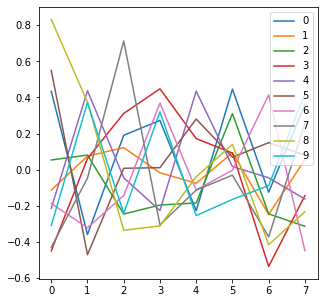

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

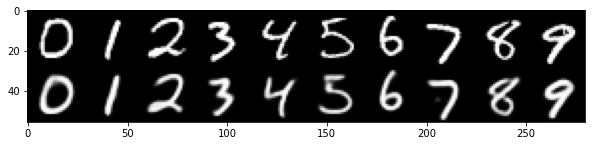

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

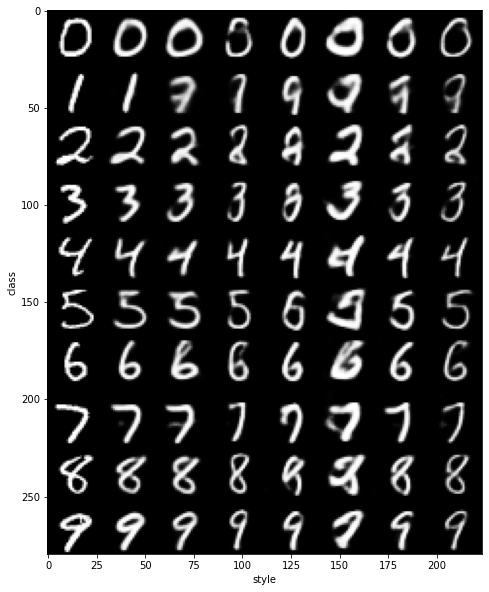

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

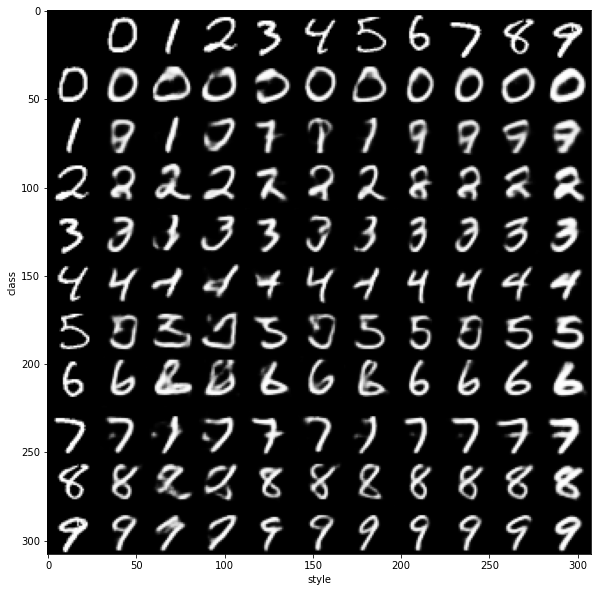

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()